In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
wind = pd.read_csv('../data/einspeisedaten_gen_wind_speed.csv')

In [3]:
def fill_missing(data):
    data = data.resample('1H').median()
    data = data.interpolate(method='time', limit_direction='both')
    return data

In [4]:
wind.head()

,dt_start_utc,voronoi_area_id,windspeed_ms
0,2018-12-31 23:00:00,1,9.523
1,2018-12-31 23:00:00,2,9.691
2,2018-12-31 23:00:00,4,14.258
3,2018-12-31 23:00:00,5,14.062
4,2018-12-31 23:00:00,6,11.504


In [5]:
#converting 'dt_start_utc' to datetime format and seting as index
wind['dt_start_utc'] = pd.to_datetime(wind['dt_start_utc'])
wind = wind.set_index('dt_start_utc')

In [6]:
#using the fill missing function to get rid of any missing values
wind_new = fill_missing(wind)

In [7]:
wind_new.head()

,voronoi_area_id,windspeed_ms
dt_start_utc,,
2018-12-31 23:00:00,57.0,13.1590
2019-01-01 00:00:00,55.5,13.7925
2019-01-01 01:00:00,55.0,14.3600
2019-01-01 02:00:00,55.0,15.0180
2019-01-01 03:00:00,55.0,14.8220


In [8]:
energy = pd.read_csv('../data/imbalance_1h.csv')

In [9]:
energy.head()

,datetime,1,2,weekday,date
0,2013-12-31 23:00:00,917.118,92.620,1,2013-12-31
1,2014-01-01 00:00:00,1264.266,82.465,2,2014-01-01
2,2014-01-01 01:00:00,746.810,50.305,2,2014-01-01
3,2014-01-01 02:00:00,-15.512,-42.080,2,2014-01-01
4,2014-01-01 03:00:00,-36.904,-28.995,2,2014-01-01


In [10]:
#Taking the subset of energy that maching well with wind speed data
energy_short = energy[(energy['datetime'] >= '2018-12-31 23:00:00') & (energy['datetime'] <= '2020-09-30 23:00:00')]

In [11]:
energy_short.head()

,datetime,1,2,weekday,date
43824,2018-12-31 23:00:00,-216.1815,-21.105,0,2018-12-31
43825,2019-01-01 00:00:00,-329.6045,-3.465,1,2019-01-01
43826,2019-01-01 01:00:00,-283.8000,-3.735,1,2019-01-01
43827,2019-01-01 02:00:00,-334.7170,-9.250,1,2019-01-01
43828,2019-01-01 03:00:00,117.6665,11.355,1,2019-01-01


In [12]:
energy_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15337 entries, 43824 to 59160
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  15337 non-null  object 
 1   1         15337 non-null  float64
 2   2         15337 non-null  float64
 3   weekday   15337 non-null  int64  
 4   date      15337 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 718.9+ KB


In [13]:
energy_short['datetime'] = pd.to_datetime(energy_short['datetime'])
energy_short = energy_short.set_index('datetime')

/var/folders/4q/jchndf6x7rv99dbr5nzt756h0000gn/T/ipykernel_29060/4181690199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_short['datetime'] = pd.to_datetime(energy_short['datetime'])


In [14]:
energy_short['wind'] = wind_new['windspeed_ms']

In [15]:
energy_short.drop(['2', 'date'], axis=1, inplace=True)

In [16]:
energy_short.head()

,1,weekday,wind
datetime,,,
2018-12-31 23:00:00,-216.1815,0,13.1590
2019-01-01 00:00:00,-329.6045,1,13.7925
2019-01-01 01:00:00,-283.8000,1,14.3600
2019-01-01 02:00:00,-334.7170,1,15.0180
2019-01-01 03:00:00,117.6665,1,14.8220


/Users/ravi/.pyenv/versions/3.9.4/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='1', ylabel='wind'>

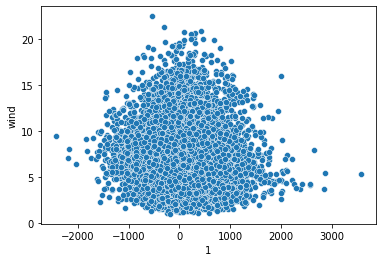

In [17]:
sns.scatterplot(energy_short['1'], energy_short['wind'])

In [18]:
energy_short.corr()

,1,weekday,wind
1,1.000000,-0.026148,-0.024280
weekday,-0.026148,1.000000,0.008468
wind,-0.024280,0.008468,1.000000


In [23]:
day_ahead = pd.read_json('../data/epex_da_de.json')

In [64]:
day_ahead.head()

,dt_start_utc,sechs_h_regelung,epex_da_de_eur_mwh,epex_da_de_mwh
0,2004-12-31 23:00:00,0,23.89,NaN
1,2005-01-01 00:00:00,0,20.05,NaN
2,2005-01-01 01:00:00,0,15.00,NaN
3,2005-01-01 02:00:00,0,13.41,NaN
4,2005-01-01 03:00:00,0,13.73,NaN


In [24]:
day_ahead['dt_start_utc'] = pd.to_datetime(day_ahead['dt_start_utc'])
day_ahead = day_ahead.set_index('dt_start_utc')

In [25]:
day_ahead = fill_missing(day_ahead)

In [70]:
day_ahead = day_ahead.reset_index()

In [71]:
day_ahead = day_ahead[(day_ahead['dt_start_utc'] >= '2018-12-31 23:00:00') & (day_ahead['dt_start_utc'] <= '2020-09-30 23:00:00')]

In [76]:
day_ahead = day_ahead.set_index('dt_start_utc')

In [77]:
energy_short['day_ahead_price'] = day_ahead['epex_da_de_eur_mwh']

In [78]:
energy_short.head()

,1,weekday,wind,day_ahead_price
datetime,,,,
2018-12-31 23:00:00,-216.1815,0,13.1590,28.32
2019-01-01 00:00:00,-329.6045,1,13.7925,10.07
2019-01-01 01:00:00,-283.8000,1,14.3600,-4.08
2019-01-01 02:00:00,-334.7170,1,15.0180,-9.91
2019-01-01 03:00:00,117.6665,1,14.8220,-7.41


In [79]:
energy_short.corr()

,1,weekday,wind,day_ahead_price
1,1.000000,-0.026148,-0.024280,0.115321
weekday,-0.026148,1.000000,0.008468,-0.236648
wind,-0.024280,0.008468,1.000000,-0.427262
day_ahead_price,0.115321,-0.236648,-0.427262,1.000000


<AxesSubplot:xlabel='1', ylabel='day_ahead_price'>

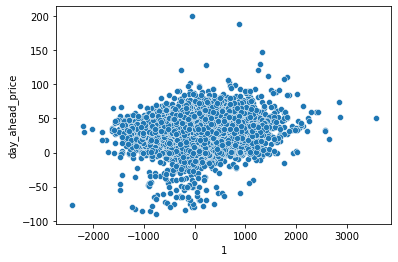

In [80]:
sns.scatterplot(data=energy_short, x='1', y='day_ahead_price')